# Lab 04: Extracting topics from research articles

# Part I: Data preprocessing

### Load dataset

- Source: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/version/1
- Download: https://georgetown.box.com/s/1qkrvdewe8ez35f2asblxysh136dvh6b

In [1]:
import pandas as pd

train_data = pd.read_csv('research-articles-dataset/train.csv').sample(frac=1)
test_data = pd.read_csv('research-articles-dataset/test.csv').sample(frac=1)

In [2]:
train_data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
18808,18809,Real-time Distracted Driver Posture Classifica...,"In this paper, we present a new dataset for ...",1,0,0,0,0,0
4256,4257,Post-edit Analysis of Collective Biography Gen...,Text generation is increasingly common but o...,1,0,0,0,0,0
14661,14662,Classification on Large Networks: A Quantitati...,"When each data point is a large graph, graph...",1,0,0,1,0,0
13646,13647,Maximally Correlated Principal Component Analysis,"In the era of big data, reducing data dimens...",1,0,0,1,0,0
10946,10947,N-body simulations of gravitational redshifts ...,Large redshift surveys of galaxies and clust...,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
523,524,Static Free Space Detection with Laser Scanner...,Drivable free space information is vital for...,1,0,0,0,0,0
2102,2103,"Non-Euclidean geometry, nontrivial topology an...",Space out of a topological defect of the Abr...,0,1,0,0,0,0
4103,4104,Deictic Image Maps: An Abstraction For Learnin...,In applications of deep reinforcement learni...,1,0,0,0,0,0
20301,20302,Type-II Dirac Photons,The Dirac equation for relativistic electron...,0,1,0,0,0,0


In [3]:
for topic in train_data.columns[3:]:
    print(f"{topic}: {sum(train_data[topic]) / len(train_data):.3f}")

Computer Science: 0.410
Physics: 0.287
Mathematics: 0.268
Statistics: 0.248
Quantitative Biology: 0.028
Quantitative Finance: 0.012


### Reuse Spacy pipeline from Lab-02 for text normalization & preprocessing

In [4]:
import re
import spacy
from spacy.language import Language

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(train_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

### Pass data through our Spacy pipeline

In [5]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))

In [6]:
print(docs[0])

paper present new dataset distracted driver posture estimation addition propose novel system achieve number number% drive posture estimation classification accuracy system consist genetically weight ensemble convolutional neural networks cnns weighted ensemble classifier genetic algorithm yield well classification confidence study effect different visual element e hand face distraction detection classification mean face hand localization finally present thin version ensemble achieve number number% classification accuracy operate realtime environment


### Compute number of unique words (vocabulary size)

In [7]:
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

16937

# Part 2: Build Features

### Build the term-document matrix (i.e., BOW features)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (2500, 2027))

### Create a index-to-word map

In [9]:
idx2word = {idx: word for word, idx in bow_featurizer.vocabulary_.items()}

### Number of topics hyperparameter

In [10]:
# Configurable
K = 10

### Plotting subroutine to visualize words

In [11]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    plt.clf()
    cols = 5
    rows = K // 5 + K % 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        if topic_idx >= len(axes):
            continue
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### (10 pts) Task I: Build a LSA model

In this task we are going to build a LSA topic model from scratch. From lecture-04, we learned about LSA from the perspective of document retrieval. For document retrieval, you'll recall that we computed a truncated SVD by choosing some number of dimension $K << N$. This gave us the left singular column vectors, $\mathbf{V} \in \mathbb{R}^{N \times K}$, and the diagonal singular value matrix, $\boldsymbol{\Sigma} \in \mathbb{R}^{K \times K}$ that we needed in order to project our queries, $\mathbf{q} \in \mathbb{R}^{N}$, and documents, $\mathbf{d} \in \mathbb{R}^{N}$, into $\mathbb{R}^{K}$ space. Recall that the operation to do that was:

$$\hat{\mathbf{q}} = \mathbf{q}\mathbf{V}\mathbf{\Sigma}^{-1} $$

In this task, we're going to evaluate the singular values, $\sigma_{i,j}$ in $\mathbf{\Sigma}$, and their corresponding basis vectors, $\mathbf{u}^{(j)}$, in $\mathbf{U}$, to extract the principal themes in the data. Execute the following subtasks.

1. For each column vector, print out the top 10 most relevant words.
2. Visualize the top 10 words using the `plot_topics()` function provided above.
3. What affect does the hyperparameter $K$ have on the result?
4. Is there a principled way to determine an appropriate value for $K$?

In [13]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [36]:
bow_sums = np.asarray(X_bow.sum(axis = 0)).flatten()
ind = np.argpartition(bow_sums, -10)[-10:]
bow_sums[ind]

array([ 983, 1050, 1282, 2013, 1127, 1051, 1105, 5836, 1068, 1334])

In [40]:
n_top_words = [idx2word[i] for i in ind]
print(n_top_words)

['algorithm', 'base', 'result', 'model', 'problem', 'propose', 'network', 'number', 'datum', 'method']


In [41]:
# plotting 6 topics based on original topics
topic = 6
X_t = X_bow.T # now our words are rows

In [52]:
X_t.shape

(2010, 2500)

In [53]:
X_bow.shape

(2500, 2010)

In [62]:
from scipy import sparse, linalg

term_correlations = np.dot(X_t, X_bow)
#sparse.csr_matrix(X_bow).multiply(sparse.csr_matrix(X_t)).todense()
#np.matmul(X_t, X_bow)

In [ ]:
# term_correlations = U*Sigma*V_T

In [85]:
svd = TruncatedSVD(100)
svd.fit(term_correlations)

TruncatedSVD(n_components=100)

In [69]:
embedding = svd.transform(term_correlations)
embedding # U * Sigma

array([[ 1.23281176e+03, -6.55333946e+01, -7.38417918e+01, ...,
        -9.17619460e+00, -2.00039079e+01, -2.68521172e+01],
       [ 1.58029168e+02,  1.58954251e+01, -2.02704938e+00, ...,
         9.27185514e-01, -3.10339664e+00, -1.79304815e+00],
       [ 4.60559912e+01,  3.19806425e+01, -2.61007648e+01, ...,
         3.89660019e+00,  6.35176748e-02, -4.32040054e-01],
       ...,
       [ 1.43349511e+02, -8.62240434e+00,  4.07950571e+00, ...,
         4.82968818e+00,  8.90605768e-01,  8.31569286e+00],
       [ 4.88429569e+02,  1.66236798e+02, -6.37887711e+01, ...,
        -1.73099612e+01,  4.27908675e+00,  3.12977151e+00],
       [ 5.12151139e+01,  3.14062169e+01,  1.89591768e+00, ...,
        -1.05252393e+00,  2.02681373e+00, -5.45552203e+00]])

In [74]:
V = svd.components_.T

In [71]:
sigma = svd.singular_values_

In [72]:
U = embedding.dot(np.linalg.inv(np.diag(sigma)))

In [75]:
np.matmul(embedding, V.T).shape

(2010, 2010)

<Figure size 432x288 with 0 Axes>

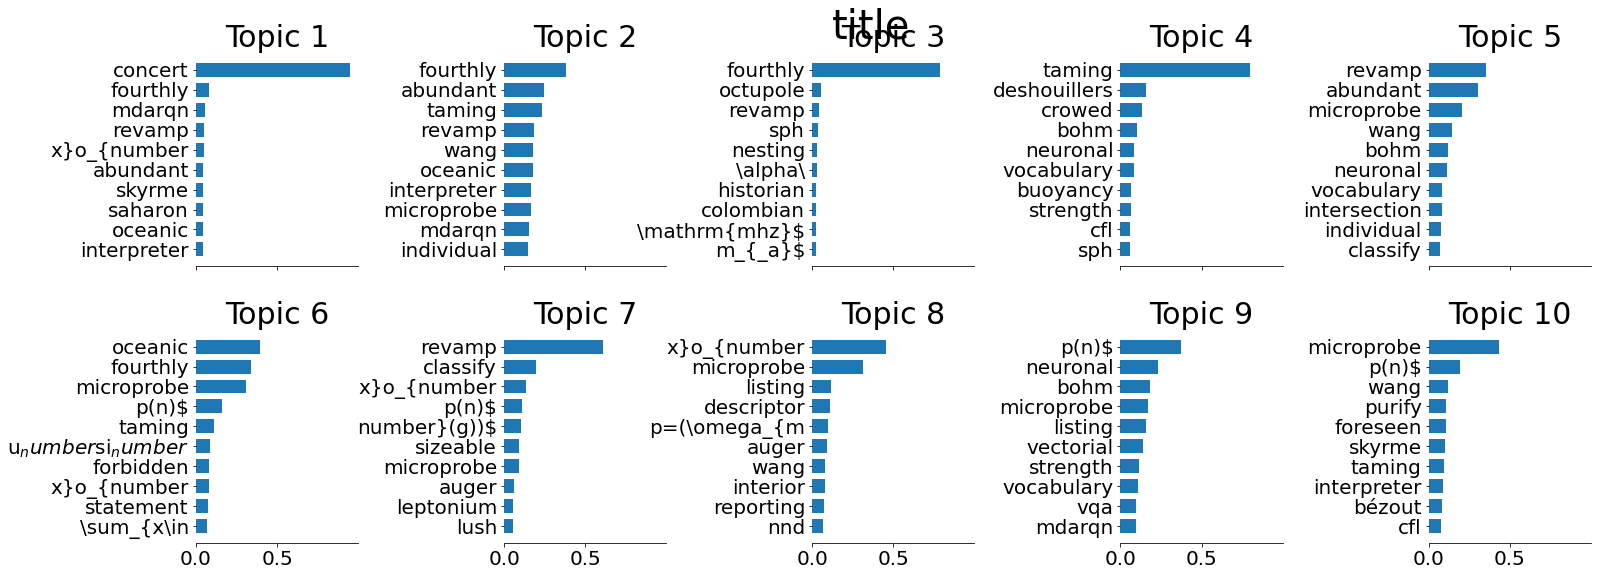

In [88]:
plot_top_words(svd, list(set(" ".join(docs).split(" "))), 10, 'title')

K is the number of topics shown in the plot

There is definitely a formula for finding K but I think it's easier to have a person choose it when tasked with a large large dataset as we have here. Knowledge of the topic is most important for chosing 

### (5 pts) Task 2: Perform topic extraction using the NMF and LDA models from sklearn

In this task we perform topic extraction using the Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) models provided by sklearn. 

1. Fit the NMF and LDA models in the provided cells below.
2. Visualize the results using the `plot_topics` function.
3. How do the results compare to your home-spun LSA topic model?
4. What are the differences between these model that might give rise to these results?

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Your code goes here

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Your code goes here

### (5 pts) Task 3: Map the test data onto the topic spaces learned from the LSA, NMF, and LDA models

The purpose of this task is to assign topics to the test data

In [ ]:
# Your code goes here